In [1]:
## Python Script for the Group Project, Stats 506 F20
##
## Linear and non-linear combinations of regression coefficients
## Data source: GLobal suicide rates from 
## https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016
##  
##
## Author: Yingyi Yang, yyingyi@umich.edu
## Updated: November 13, 2020

#! Limit lines to 79 characters with rare exceptions. 
# 79: -------------------------------------------------------------------------

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
import statsmodels.api as sm
from itertools import combinations_with_replacement 
import matplotlib.pyplot as plt
import os

### 1. Data preprocessing 

In [3]:
url = "https://raw.githubusercontent.com/aravind1338/506F20GroupProject/main/master.csv"
df = pd.read_csv(url, index_col=0)

In [4]:
df.rename(columns = {"suicides/100k pop": "suicides_per_100k", "gdp_per_capita ($)": "gdp_per_capita"}, inplace=True)

In [5]:
df.reset_index(inplace = True)

### 2. Fitted Poisson model

In [6]:
fml = "suicides_no ~ C(year) + C(sex) + C(age) + gdp_per_capita"
model = sm.GLM.from_formula(fml, offset=np.log(df['population']), data=df, family=sm.families.Poisson())
res = model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            suicides_no   No. Observations:                27820
Model:                            GLM   Df Residuals:                    27781
Model Family:                 Poisson   Df Model:                           38
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6427e+06
Date:                Wed, 25 Nov 2020   Deviance:                   3.1549e+06
Time:                        17:12:42   Pearson chi2:                 3.58e+06
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -10.21

In [7]:
cov_matrix = res.cov_params()
coeffs = res.params

### 3. Linear combination 

In [8]:
def lcom(var_list, coeffs, cov_matrix, alpha=0.05):   
    # Function to calculate estimate, std error and confidence intervals
    # Inputs: var_list - a list of variables to compare (3 items expected)
    #         coeffs - the fitted coefficients of the model
    #         cov_matrix - the variance/covariance matrix of the parameter estimates     
    # Output: a dataframe containing the estimate, std error, lower and upper limits
    #         for the linear combination
   
    trans_list = ['Intercept']
    coeffs_list = [coeffs['Intercept']]
       
    for name in var_list:
        if "age" in name:
            trans = "C(age)[T."+name[3:]+"]"
        elif "sex" in name:
            trans = "C(sex)[T."+name[3:]+"]"
        elif "year" in name:
            trans = "C(year)[T."+name[4:]+"]"
        if trans in coeffs.index:
            trans_list.append(trans)
            coeffs_list.append(coeffs[trans])
    
    linear_est = sum(coeffs_list)
    score = stats.t.ppf(1-alpha/2, res.df_resid)

    variance = 0
    for a, b in combinations_with_replacement(trans_list, 2):
        if a == b:
            variance += cov_matrix[a][b]
        else:
            variance += 2*cov_matrix[a][b]
    
    output = pd.DataFrame({"estimate": [np.exp(linear_est)], 
                           "se": [np.exp(linear_est)*np.sqrt(variance)],
                           "lower": [np.exp(linear_est)-score*np.exp(linear_est)*np.sqrt(variance)], 
                           "upper": [np.exp(linear_est)+score*np.exp(linear_est)*np.sqrt(variance)]})
    
    return output

### 4. Nonlinear combination 

In [9]:
def nlcom(var_list, coeffs, cov_matrix, alpha=0.05, method="ratio"):
    # Function to calculate estimate, std error and confidence intervals
    # Inputs: var_list - a list of variables to compare (3 items expected)
    #         coeffs - the fitted coefficients of the model
    #         cov_matrix - the variance/covariance matrix of the parameter estimates
    #         method - nonlinear combination method
    # Output: a dataframe containing the estimate, std error, lower and upper limits
    #         for the linear combination
    
    trans_list = ['Intercept']
    coeffs_list = []
       
    for name in var_list:
        if "age" in name:
            trans = "C(age)[T."+name[3:]+"]"
        elif "sex" in name:
            trans = "C(sex)[T."+name[3:]+"]"
        elif "year" in name:
            trans = "C(year)[T."+name[4:]+"]"
        if trans in coeffs.index:
            trans_list.append(trans)
            coeffs_list.append(coeffs[trans])
            
    if method == 'product':
        beta1, beta2 = coeffs[trans_list[1]], coeffs[trans_list[2]]
        est = np.exp(beta1*beta2)
        G = np.matrix([0,est*beta2,est*beta1])
        V = cov_matrix[trans_list].loc[trans_list,:]
        vcov = np.matrix(V)
        se   = np.sqrt(G.dot(vcov).dot(G.T))
        score = stats.t.ppf(1-alpha/2, res.df_resid)
        ci_l = est - score*se[0,0]
        ci_u = est + score*se[0,0]
            
    if method == 'ratio':
        beta1, beta2 = coeffs[trans_list[1]], coeffs[trans_list[2]]
        est = np.exp(beta1/beta2)
        G = np.matrix([0,est*1./beta2,est*(-beta1/(beta2**2))])
        V = cov_matrix[trans_list].loc[trans_list,:]
        vcov = np.matrix(V)
        se   = np.sqrt(G.dot(vcov).dot(G.T))
        score = stats.t.ppf(1-alpha/2, res.df_resid)
        ci_l = est - score*se[0,0]
        ci_u = est + score*se[0,0]
        
    output = pd.DataFrame({"estimate": [est], 
                           "se": [se[0,0]],
                           "lower": [ci_l], 
                           "upper": [ci_u]})
    
    if method == 'product':
        output.index = ['product']
    if method == 'ratio':
        output.index = ['ratio']
    
    return output    

In [10]:
nlcom(['year2000','year2010'], coeffs, cov_matrix, alpha=0.05, method="ratio")

,estimate,se,lower,upper
ratio,0.124771,0.017357,0.09075,0.158791


In [11]:
nlcom(['sexmale','year2005'], coeffs, cov_matrix, alpha=0.05, method="product")

,estimate,se,lower,upper
product,1.086333,0.005124,1.076289,1.096377


### 5. Visualization 

In [12]:
def plot_comparison(var_list1, var_list2):
    # Function to generate bar plot of estimate and confidence interval
    # Inputs: var_list1 - a list of 3 variables to compare
    #         var_list2 - variable list with 1 different from var_list1
    
    common = list(set(var_list2).intersection(var_list1))
    
    df1 = lcom(var_list1, coeffs, cov_matrix, alpha=0.05)
    df1.index = list(set(var_list1)-set(common))
    df2 = lcom(var_list2, coeffs, cov_matrix, alpha=0.05)
    df2.index = list(set(var_list2)-set(common))
    df = df1.append(df2)
    
    est = np.array(df['estimate'])
    ci = np.array([df1[['lower','upper']].values[0], df2[['lower','upper']].values[0]])

    x_r = np.c_[est-ci[:,0],ci[:,1]-est].T
    plt.figure(figsize=(15,4))
    plt.barh(range(len(est)), est, xerr=x_r, fill=False, ecolor='r', capsize=20)
    plt.xlabel('Linear combination of coefficients (95% CI)')
    plt.yticks(range(len(est)), [str(lab) for lab in df.index])
    plt.title(str(common))
    plt.show()
    
    return df

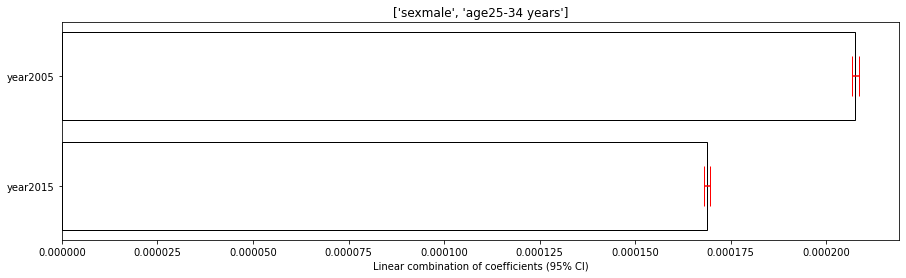

,estimate,se,lower,upper
year2015,0.000169,4.172158e-07,0.000168,0.000170
year2005,0.000208,4.796980e-07,0.000207,0.000209


In [13]:
var_list1 = ["sexmale", "age25-34 years", "year2015"]
var_list2 = ["sexmale", "age25-34 years", "year2005"]

plot_comparison(var_list1, var_list2)

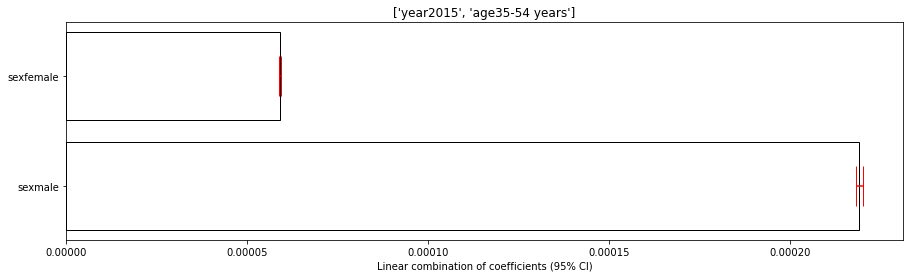

,estimate,se,lower,upper
sexmale,0.000219,5.214398e-07,0.000218,0.00022
sexfemale,0.000059,1.466505e-07,0.000059,0.00006


In [14]:
var_list1 = ["sexmale", "age35-54 years", "year2015"]
var_list2 = ["sexfemale", "age35-54 years", "year2015"]

plot_comparison(var_list1, var_list2)

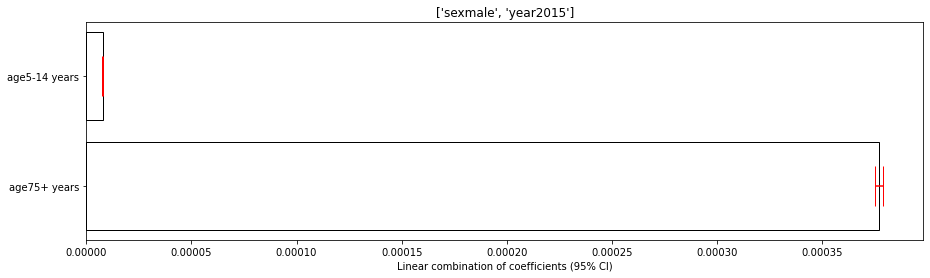

,estimate,se,lower,upper
age75+ years,0.000377,9.923070e-07,0.000375,0.000379
age5-14 years,0.000008,3.836909e-08,0.000008,0.000008


In [15]:
var_list1 = ["sexmale", "age75+ years", "year2015"]
var_list2 = ["sexmale", "age5-14 years", "year2015"]

plot_comparison(var_list1, var_list2)